# Problem sheet 1 - Q2: Locally-weighted logistic regression

> **Disclaimer:** Some of the formulas are directly copied from the homework sheet for the sake of convenience and clarity of exposition.

1. [Setup](#1)
2. [Implementation](#2)
3. [Data preparation and fitting](#3)
4. [Model evaluation](#4)
5. [Next steps](#5)

In this question we need to construct a locally-weighted logistic regression (LWLR) model by using the Newton-Rhapsod method. Recall that the log likelihood of a LWLR is given by
$$\ell(\theta)= -\frac{\lambda}{2}\theta^{T}\theta+\sum_{i=1}^{m}w^{(i)}\left[
y^{(i)}\log h_{\theta}(x^{(i)}) + (1-y^{(i)})\log(1-h_{\theta}(x^{(i)})\right],$$
where $\lambda>0$ is a regularisation parameter, $\theta\in\mathbb{R}^{n+1}$ is the set of parameters of our model (the first coordinate corresponds to the bias term so that the number of input features is $n$), $m$ is the number of training examples, $h_{\theta}$ is our hypothesis (with sigmoid activation), and $x^{(i)}$, $y^{(i)}$, $w^{(i)}$ denote the $i$-th training sample, its corresponding target class and the computed weight, respectively. The problem of finding the optimal parameter vector $\theta$ then corresponds to maximising $\ell(\theta)$. We will denote the matrix of all training samples by $X\in\mathbb{R}^{m\times (n+1)}$, where we assume the first column consists of only 1's and each row corresponds to one training sample.

The Newton-Rhapsod method (applied to $\nabla\ell$, because we want to find the critical point) says that to find a zero of the function, we need to iterate over the variable $\theta$ (with some initial guess $\theta_{0}$)
according to the rule
$$\theta_{i+1}=\theta_{i} - H^{-1}\nabla_{\theta}\ell(\theta_{i}),$$
which gives us a sequence $\theta_{i}$ converging to the maximising parameters. It is a global maximum since $\ell$ is convex. To see this let's consider a simpler one dimensional function
$$f(u) = -\frac{\lambda}{2}u^{2}+w\log g(u),$$
where $g(u)=(1+e^{-u})^{-1}$ is the sigmoid function. Since $g'(u)=g(u)(1-g(u))$ and $0<g(u)<1$, we can easily see that $f''(u)<0$ for all $u$. Thus $f$ is concave. Moreover, notice that $1-g(u)=g(-u)$. The generalisation to the multidimensional case (i.e. verifying that the Hessian is negative semi-definite) is straightforward.

In the case of LWLR the gradient is
$$\nabla \ell(\theta) = X^{T}z - \lambda\theta,$$
where $z\in\mathbb{R}^{m}$ is given by
$$z_{i}=w^{(i)}(y^{(i)}-h(x^{(i)})).$$
The Hessian is
$$H=X^{T}DX - \lambda I,$$
where $D\in\mathbb{R}^{m\times m}$ is a diagonal matrix with diagonal entries
$$D_{ii}=-w^{(i)}h(x^{(i)})(1-h(x^{(i)}).$$
We use the following exponential weights
$$w^{(i)} = \exp\left(-\frac{(x_{0}-x^{(i)})^{T}(x_{0}-x^{(i)})}{2\tau^{2}}\right),$$
where $\tau$ is the so-called *bandwidth parameter*, which roughly speaking controls the area of influence of each point. We now have everything we need to implement LWLR.

## 1. Setup<a id="1"></a>

Here we simulate our data with a similar scheme as in Chapter 2 of Elements of Statistical Learning by Hastie et al. That is, for $i=1,\ldots,10$, we sample $\mu_{i}$ and $\psi_{i}$ from bivariate normal distribution with means $(0, 1)$ and $(1, 0)$, respectively. Then to obtain negative and positive data points, we consider the set of distributions $\{N(\mu_{i}, I/5)\}_{i}$ and $\{N(\psi_{i}, I/5)\}$ (where $I$ is the identity matrix). For each point in the negative class we pick one $i\in\{1, \ldots, 10\}$ at uniform random and then sample $x^{(j)}$ from $N(\mu_{i}, I/5)$ to obtain the negative data point $(x^{(j)}, 0)$. Similarly for positive samples.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

rng = np.random.default_rng(2)
means_neg = rng.multivariate_normal([0,1], np.ma.identity(2), size=10)
means_pos = rng.multivariate_normal([1,0], np.ma.identity(2), size=10)
samples_neg = np.zeros((100,2))
samples_pos = np.ones((100,2))
for i in range(100):
    i_neg, i_pos = rng.integers(10, size=2)
    samples_neg[i, :] = rng.multivariate_normal(means_neg[i_neg], np.ma.identity(2) / 5)
    samples_pos[i, :] = rng.multivariate_normal(means_pos[i_pos], np.ma.identity(2) / 5)

X_train = np.concatenate([samples_neg, samples_pos])
y_train = np.concatenate([np.zeros((100,1)), np.ones((100,1))])

We obtain a total of 100 positive and 100 negative samples, which are plotted below. Here blue marks correspond to target value 0 and orange to 1.

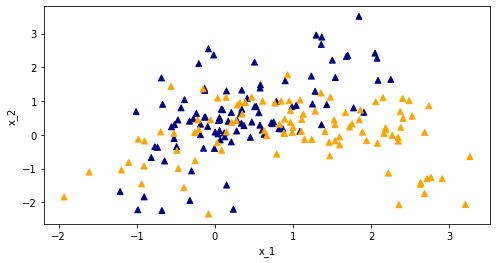

In [2]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
# for manual colours use:
colors = ['navy','orange']
# and  cmap=matplotlib.colors.ListedColormap(colors) in scatter plot
ax.scatter(*tuple(map(tuple,X_train.T)), marker='^', c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
plt.show()

## 2. Implementation<a id="2"></a>

We now define all the functions needed for one iteration of Newton-Rhapsod in `newton_iter(X, y, theta, w, reg_l)`. The inputs should be self-explanatory based on the discussion above.

In [3]:
# Throughout we will assume the following regarding the sizes of the inputs:
#    X is m x (n+1),
#    theta is (n+1) x 1,
#    x_0 is n x 1,
#    w is m x 1,
#    y is m x 1,
#    and all other inputs are scalars

def sigmoid(z):
    return 1 / (1 + np.exp(-z))
    
    
def h(X, theta):
    """
    return m x 1
    """
    return sigmoid(X @ theta)


def weights(X, x_0, tau):
    """
    return m x 1
    """
    return np.reshape(np.exp(-np.sum(np.power(X - x_0.T, 2), axis=1) / (2 * tau ** 2)), (-1,1))


def D(X, w, hyp):
    """
    return m x m diagonal matrix
    """
    
    return np.diagflat(- w * hyp * (1 - hyp))

                  
def Hessian(X, w, hyp, reg_l):
    """
    return (n+1) x (n+1)
    """
    return X.T @ D(X, w, hyp) @ X - reg_l * np.identity(X.shape[1])

                  
def gradL(X, w, y, hyp, theta, reg_l):
    """
    return (n+1) x 1
    """
    z = w * (y - hyp)  # z is m x 1
    return X.T @ z - reg_l * theta


def newton(X, y, tau, reg_l, x_0):
    w = weights(X, x_0, tau)
    theta = np.zeros((X.shape[1], 1))
    grad = np.ones(theta.shape)
    
    while np.linalg.norm(grad) > 0.0000001:
        hyp = h(X, theta)
        grad = gradL(X, w, y, hyp, theta, reg_l)
        H = Hessian(X, w, hyp, reg_l)
        theta = theta - np.linalg.inv(H) @ grad
    return theta


def predict(X, y, x_0, tau, reg_l):
    x_0 = np.array(x_0)
    # To add an intercept term you can uncomment these:
    # X = np.hstack([np.ones((X.shape[0],1)), X])
    # x_0 = np.hstack([[1.0],x_0])
    theta = newton(X, y, tau, reg_l, x_0)
    # classifying when h(x) > 0.5 corresponds to x * Theta > 0
    return int((x_0.T @ theta) > 0)

## 3. Data preparation and fitting<a id="3"></a>

First we add a column of ones to the training data and set values for our parameters. `n_iters` corresponds to the number of iterations we want to run Newton's method for and `x_0` is the point we want to use for the localisation (in computing the weights). Recall that in the final parameter vector the first element corresponds to the intercept. We then visualise our classifier by plotting the decision boundary given by the function `predict` (with threshold 0.5) defined above.

In [4]:
#step size for plotting:
step = 0.01

#bandwidth:
tau = 0.5

#regularisation parameter:
reg_l = 0.0001

min_x1, min_x2 = np.min(X_train[:,0]), np.min(X_train[:,1])
max_x1, max_x2 = np.max(X_train[:,0]), np.max(X_train[:,1])

margin = 0.1

grid_x1 = np.arange(min_x1 - margin, max_x1 + margin, step)
grid_x2 = np.arange(min_x2 - margin, max_x2 + margin, step)
xx, yy = np.meshgrid(grid_x1, grid_x2, indexing='ij')

zz = np.zeros(xx.shape)

for i in range(len(grid_x1)):
    for j in range(len(grid_x2)):
        zz[i, j] = predict(X_train, y_train, [xx[i,j], yy[i,j]], tau, reg_l)

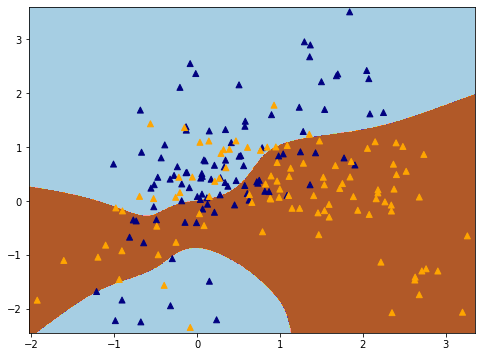

In [5]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.contourf(xx, yy, zz, cmap='Paired')
ax.scatter(*tuple(map(tuple,X_train.T)), marker='^', c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

We notice that the algorithm outputs a seemingly robust partition of the input space. The downside is that the algorithm is computationally very expensive since at each point in the grid we're fitting the model from scratch (since `x_0` varies).

## 4. Model evaluation<a id="4"></a>

To check for the correctness of our model we also fit a standard (unweighted) logistic regression model via `sklearn`. If we let the bandwidth parameter $\tau$ tend to $\infty$ then the weights tend to 1 so that LWLR approaches the unweighted logistic regression mode. By modifying the parameters in the previous section it is possible to verify that the decision boundary of our model indeed tends to the one plotted below. Thus it is plausible that our model is working as intended.

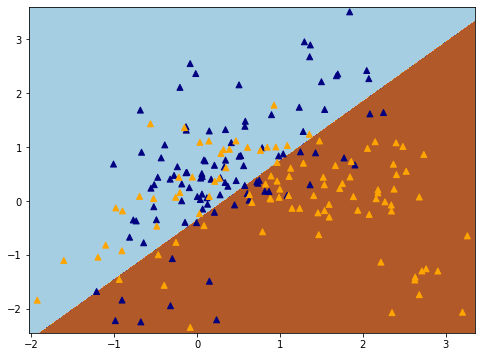

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=1)
model.fit(X_train, y_train.ravel())

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))
yhat = model.predict(grid)
# reshape the predictions back into a grid
zz_model = yhat.reshape(xx.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.contourf(xx, yy, zz_model, cmap='Paired')
ax.scatter(*tuple(map(tuple,X_train.T)), marker='^', c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

## 5. Next steps<a id="5"></a>

Here are some ideas for further implementations:

- Visualise the "area of influence" determined by the weights.
- Generalise to multiclass classification.
- Include learning curves to see how effective the training is and to help us pick the hyperparameters.